<img src="https://healthitanalytics.com/images/site/article_headers/_normal/ThinkstockPhotos-495951912.jpg">

- Aim
  -  Create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.
  
- Techniques
  - Check the distribution of labels 
  - Take a random look at a certain set of images to check for any noticable difference
  - Check variation of the color channels in a cancerous and non cancerous image
  - Apply image augmentations based on the features noticed above
  - Apply transfer learning on the training set using VGG19 architecture.
  - Apply model on the test set. 

# Libraries

In [1]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

import numpy as np 

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import keras
from keras import losses
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation,Flatten, Dropout, Dense
from keras.layers.convolutional import MaxPooling2D
from keras import Model
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.optimizers import Nadam,Adam

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import glob





  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-ca_nuccz
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-ca_nuccz
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=28014 sha256=8f0f88c0df72db21ccf8fc40fb29aae933c32e7a360649ce49dfea2037105632
  Stored in directory: /tmp/pip-ephem-wheel-cache-arscy5c_/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Using TensorFlow backend.


# References
- https://www.kaggle.com/sdelecourt/cnn-with-keras
- https://www.alibabacloud.com/blog/part-3-image-classification-using-features-extracted-by-transfer-learning-in-keras_595291
- https://www.kaggle.com/frlemarchand/transfer-learning-for-cancer-detection-keras

# Extract tabular data

In [2]:
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(df.head(10))

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
5  acfe80838488fae3c89bd21ade75be5c34e66be7      0
6  a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da      1
7  7f6ccae485af121e0b6ee733022e226ee6b0c65f      1
8  559e55a64c9ba828f700e948f6886f4cea919261      0
9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4      0


In [3]:
column_names = list(df.columns)
print(len(df))

print(len(df[column_names[0]].unique()))
print(df[column_names[1]].unique())
# No duplciate rows

220025
220025
[0 1]


In [4]:
df['id']=df['id'].apply(lambda x: x+'.tif')
print(df['id'])

0         f38a6374c348f90b587e046aac6079959adf3835.tif
1         c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2         755db6279dae599ebb4d39a9123cce439965282d.tif
3         bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4         068aba587a4950175d04c680d38943fd488d6a9d.tif
                              ...                     
220020    53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6.tif
220021    d4b854fe38b07fe2831ad73892b3cec877689576.tif
220022    3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75.tif
220023    f129691c13433f66e1e0671ff1fe80944816f5a2.tif
220024    a81f84895ddcd522302ddf34be02eb1b3e5af1cb.tif
Name: id, Length: 220025, dtype: object


# Check distribution of labels

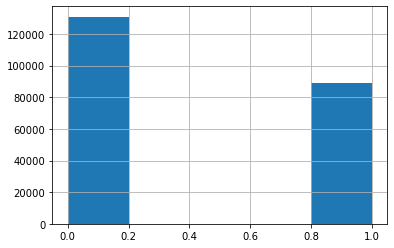

In [5]:
hist = df['label'].hist(bins=5)

- Almost fair distribution of labels

# Look at random set of images for any noticable difference

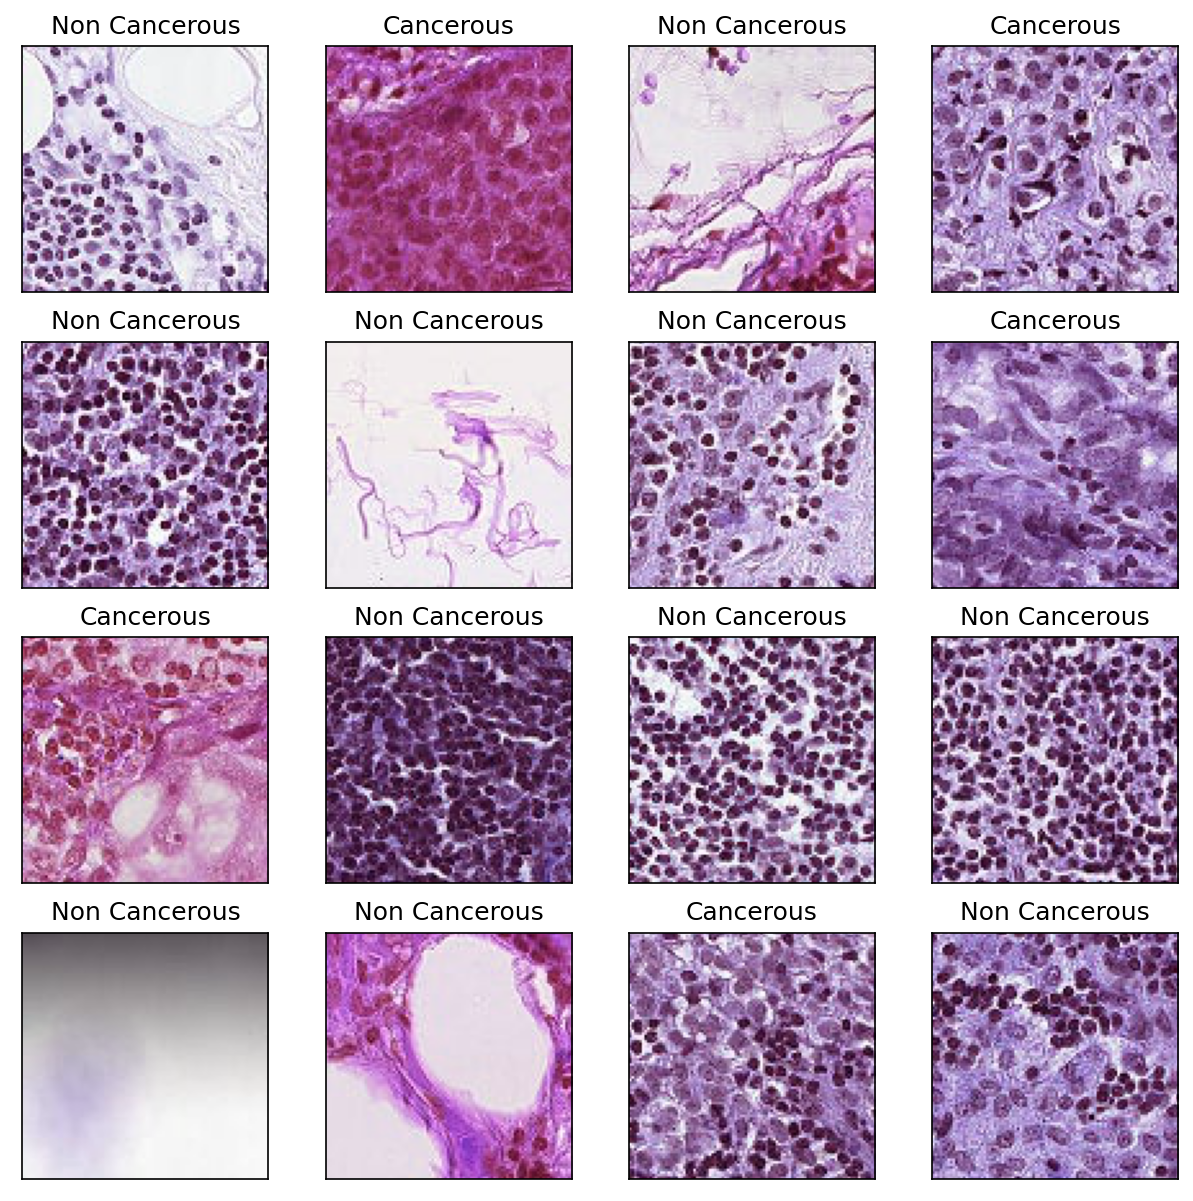

In [6]:
fig, axs = plt.subplots(4,4,figsize=(10, 10), dpi=150)


images = []
for i in range(4):
    for j in range(4):
        
        No = np.random.randint(0,2000)
                
        image = cv2.imread('../input/histopathologic-cancer-detection/train/'+ df.iloc[No]['id'])
        images.append(axs[i, j].imshow(image))
        
        if df.iloc[No]['label'] == 1:
            axs[i,j].set_title('Cancerous')
        else:
            axs[i,j].set_title('Non Cancerous')
            
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        

    
plt.show()
# This will be helpful for image augmentations, like we can do do channel shuffling in order for the model to extract features well or
# contrast enhancement to make features distinguishable.
del images

- From the above it is difficult to ascertain the features that distinguish between the cancerous and non cancerous cells
- There are images of cancerous and non cancerous cells with similar colors.
- Also, there are images of cancerous and non cancerous with high and low number of circular nodes.
- Let's look at the frequency count of the color channels of a random image from each category.

# Check frequency count of the color channels

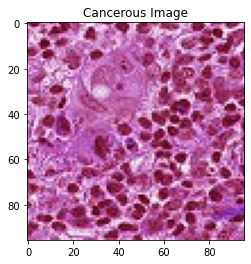

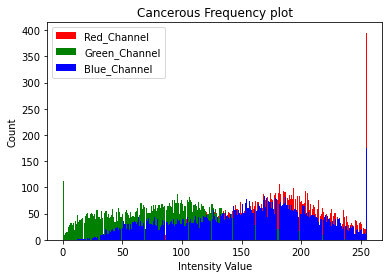

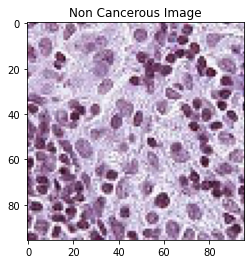

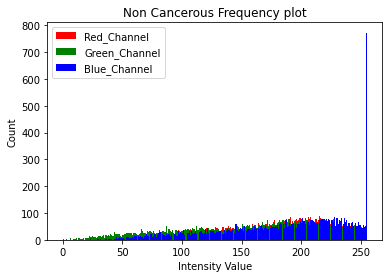

In [7]:
malignant_data = df[(df.label==1)]
malignant_image = malignant_data.iloc[1000]['id']

img = cv2.imread('../input/histopathologic-cancer-detection/train/'+malignant_image)
plt.imshow(img)
plt.title("Cancerous Image")
plt.show()
plt.hist(img[:, :,  0].ravel(), bins = 256, color = 'red')
plt.hist(img[:, :, 1].ravel(), bins = 256, color = 'Green')
plt.hist(img[:, :, 2].ravel(), bins = 256, color = 'Blue')
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.title("Cancerous Frequency plot")
plt.show()

benign_data = df[(df.label==0)]
benign_image = benign_data.iloc[1]['id']

img = cv2.imread('../input/histopathologic-cancer-detection/train/'+benign_image)
plt.imshow(img)
plt.title("Non Cancerous Image")
plt.show()
plt.hist(img[:, :, 0].ravel(), bins = 256, color = 'red')
plt.hist(img[:, :, 1].ravel(), bins = 256, color = 'Green')
plt.hist(img[:, :, 2].ravel(), bins = 256, color = 'Blue')
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.title("Non Cancerous Frequency plot")
plt.show()

del img,benign_data,malignant_data

- Frequency in a cancerous image more spread out as compared to a non cancerous image
- However, this could vary from image to image

# Image Augmentation

-  Apart from flipping and rotating the images, we can apply other augmentations
-  We can reduce contrast of the image to bring down the effect of the color channels.
-  And apply CLAHE (Contrast Limited Adaptive histogram equalization) to improve the contrast in the image to pick up the effect of the features and the color channel

In [8]:
AUGMENTATIONS = albumentations.Compose([
    
    albumentations.Flip(p=0.5),
    albumentations.Rotate(p=0.5),    
    albumentations.CLAHE(p=0.3), 
    albumentations.RandomContrast(p=0.3) # (Default varies from -0.2 to 0.2)
    
]) 

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS
      )

# Splitting into training, validation and testing sets

In [9]:
df['label'] = df['label'].astype('str')

train, test = train_test_split(df, test_size=0.2,random_state=42)
train, valid = train_test_split(train, test_size=0.1,random_state=42)

train_path = '../input/histopathologic-cancer-detection/train/'
valid_path = '../input/histopathologic-cancer-detection/train/'

train_generator = train_datagen.flow_from_dataframe(
                dataframe=train,
                directory=train_path,
                x_col = 'id',
                y_col = 'label',
                shuffle=True,
                subset='training',
                target_size=(94, 94),
                batch_size=64,
                class_mode="binary"
                )

valid_datagen = ImageDataAugmentor(
        rescale=1./255, )

validation_generator = valid_datagen.flow_from_dataframe(
                dataframe=valid,
                directory=valid_path,
                x_col = 'id',
                y_col = 'label',
                subset=None, 
                target_size=(94, 94),
                batch_size=64,
                shuffle=True,
                class_mode="binary"
                )

Found 158418 validated image filenames belonging to 2 classes.
Found 17602 validated image filenames belonging to 2 classes.


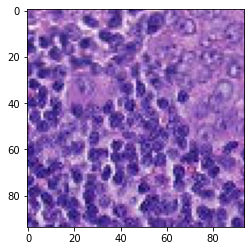

In [10]:
plt.imshow(train_generator[0][0][1])

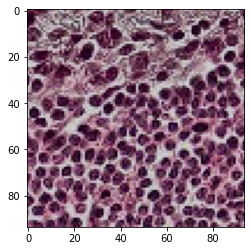

In [11]:
plt.imshow(train_generator[0][0][2])

# Model Structure adapted from VGG19

In [12]:
image_shape = (94,94, 3)

# Define base_model
TLModel = keras.applications.VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(image_shape))

# Make the botton 8 layers trainable
for layer in TLModel.layers[:-8]:
    layer.trainable = False


x = TLModel.output
x = GlobalAveragePooling2D()(x)

# Helps to learn new features
x = Dense(1000,activation='relu')(x)
x = Dense(500,activation='relu')(x)
x = Dense(500,activation='relu')(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=TLModel.input, outputs=output)
    
model.summary()



80142336/80134624 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 94, 94, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 94, 94, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 94, 94, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 47, 47, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 47, 47, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 47, 47, 128)       147584    
____________________________________________________________

In [13]:
opt = Nadam()
model.compile(optimizer= opt, loss=losses.binary_crossentropy, metrics=['accuracy'])

# Implementing Results on Model

In [14]:
earlyStop = EarlyStopping(monitor='val_accuracy', mode='max',patience= 4)
Checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True,mode='max',verbose=1)

StepSizeTrain= int(train_generator.n/train_generator.batch_size)
StepSizeValid= int(validation_generator.n/validation_generator.batch_size)

hist = model.fit_generator(
                train_generator,
                steps_per_epoch=StepSizeTrain,
                validation_steps=StepSizeValid,
                epochs=25,
                validation_data=validation_generator
                ,callbacks=[earlyStop,Checkpoint],verbose=1)



Epoch 1/25
2475/2475 [==============================] - 502s 203ms/step - loss: 0.3469 - accuracy: 0.8510 - val_loss: 0.2831 - val_accuracy: 0.8737

Epoch 00001: val_accuracy improved from -inf to 0.87375, saving model to best_model.h5
Epoch 2/25
2475/2475 [==============================] - 244s 99ms/step - loss: 0.2958 - accuracy: 0.8784 - val_loss: 0.3754 - val_accuracy: 0.8344

Epoch 00002: val_accuracy did not improve from 0.87375
Epoch 3/25
2475/2475 [==============================] - 241s 97ms/step - loss: 0.2761 - accuracy: 0.8872 - val_loss: 0.1792 - val_accuracy: 0.8914

Epoch 00003: val_accuracy improved from 0.87375 to 0.89144, saving model to best_model.h5
Epoch 4/25
2475/2475 [==============================] - 246s 100ms/step - loss: 0.2644 - accuracy: 0.8927 - val_loss: 0.1991 - val_accuracy: 0.8841

Epoch 00004: val_accuracy did not improve from 0.89144
Epoch 5/25
2475/2475 [==============================] - 245s 99ms/step - loss: 0.2555 - accuracy: 0.8972 - val_loss: 0.

# Plot training - validation accuracy and loss curves to check for over and underfitting

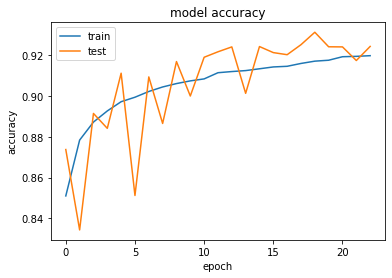

In [15]:
# Summarize Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

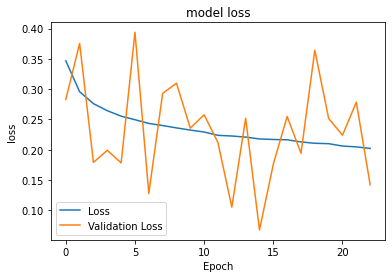

In [16]:
# Summarize Loss 
plt.plot(hist.history["loss"])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

- Testing accuracy higher than the training accuracy. This means model is not overfitting.
- Also a higher accuracy suggest model is not underfitting. 

# Testing on testing set which was seperated from training set

In [17]:
test_datagen = ImageDataAugmentor(rescale=1./255)

test_path = '../input/histopathologic-cancer-detection/train/'
test_gen = test_datagen.flow_from_dataframe(
                dataframe=test,
                directory=test_path,
                x_col = 'id',
                y_col = 'label',      
                target_size=(94, 94),
                batch_size=1,
                shuffle=False,
               class_mode="binary"
                ) 



Found 44005 validated image filenames belonging to 2 classes.


In [18]:
model.load_weights("best_model.h5")

# make predictions
predictions = model.predict_generator(test_gen, steps=len(test_gen), verbose=1)
False_Positive_rate, True_Positive_rate, Thresholds = roc_curve(test_gen.classes, predictions)
AUC = auc(False_Positive_rate, True_Positive_rate)

44005/44005 [==============================] - 220s 5ms/step


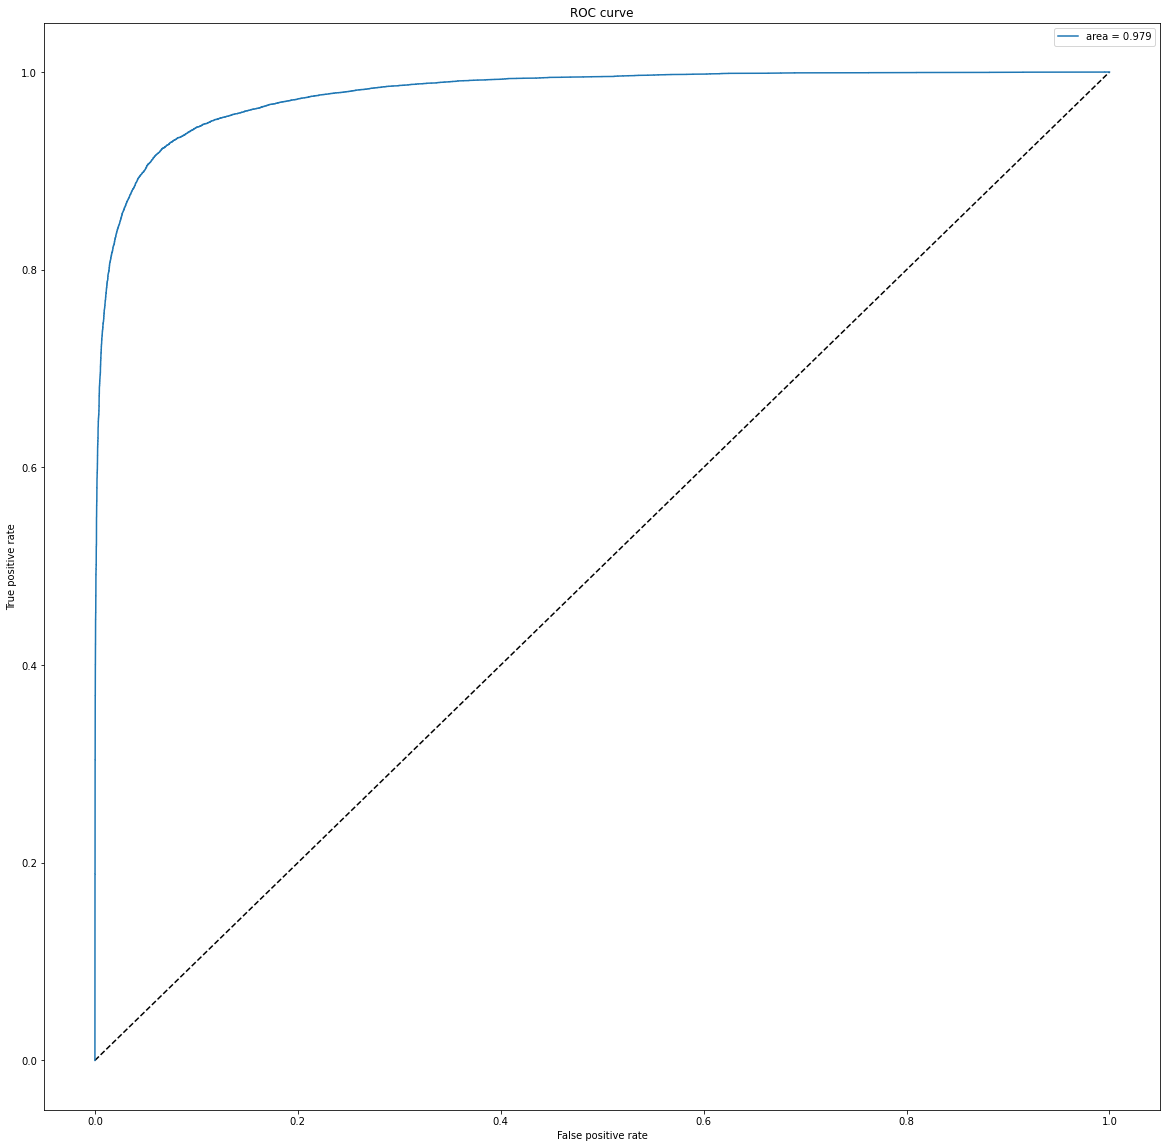

In [19]:
plt.figure(figsize=(20,20))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(False_Positive_rate, True_Positive_rate, label='area = {:.3f}'.format(AUC))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [20]:
del test_gen, train_generator, validation_generator

# Applying on testing set

In [21]:
test  = pd.DataFrame()
test_fileNames = [file for file in glob.glob("../input/histopathologic-cancer-detection/test/*.tif")]

test_fileNames.sort()

FileNames = []
for name in test_fileNames:
    Name = name.replace("../input/histopathologic-cancer-detection/test/", "")
    FileNames.append(Name)
    
test['id'] = FileNames

In [22]:
test_datagen = ImageDataAugmentor(rescale=1./255)

test_path = '../input/histopathologic-cancer-detection/test/'
test_gen = test_datagen.flow_from_dataframe(
                dataframe=test,
                directory=test_path,
                x_col = 'id',
                y_col = None,
                class_mode=None,
                target_size=(94, 94),
                batch_size=1,
                shuffle=False,   
                ) 

Found 57458 validated image filenames.


In [23]:
predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)

57458/57458 [==============================] - 288s 5ms/step


In [24]:
output = pd.DataFrame()

output['id'] = test_gen.filenames
output['id'] = output['id'].str.replace('.tif','')
output['label'] = predictions


output.to_csv("submission.csv",index=False)
print(output)

                                             id     label
0      00006537328c33e284c973d7b39d340809f7271b  0.956184
1      0000ec92553fda4ce39889f9226ace43cae3364e  0.861660
2      00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.962701
3      000253dfaa0be9d0d100283b22284ab2f6b643f6  0.943878
4      000270442cc15af719583a8172c87cd2bd9c7746  0.005778
...                                         ...       ...
57453  fffdd1cbb1ac0800f65309f344dd15e9331e1c53  0.003317
57454  fffdf4b82ba01f9cae88b9fa45be103344d9f6e3  0.070029
57455  fffec7da56b54258038b0d382b3d55010eceb9d7  0.005384
57456  ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6  0.083922
57457  ffffeb4c0756098c7f589b7beec08ef1899093b5  0.025570

[57458 rows x 2 columns]


- Would appreciate feedback